In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install tensorflow==2.5.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras==2.4.3

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

In [10]:
NUM_CLASSES = 3 #3 sınıf
CHANNELS = 3 # görüntü renk kanalı

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3
BATCH_SIZE_TRAINING=32
BATCH_SIZE_VALIDATION=32
BATCH_SIZE_TESTING=1
#STEPS_PER_EPOCH_TRAINING = 376
#STEPS_PER_EPOCH_VALIDATION = 34

In [3]:
import tensorflow 
from tensorflow .keras.applications import ResNet50
from tensorflow .keras.models import Sequential
from tensorflow .keras.layers import Dense,Dropout

In [4]:
resnet_weights_path ='imagenet'

In [5]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE,#pooling=GlobalAveragePooling2D,
                   weights = resnet_weights_path))
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
#model.add(Dense(1024,activation='relu'))
#model.add(Dropout(0.5))
model.layers[0].trainable = False

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


In [7]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [11]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
path=r'C:\\Users\\Tri\\Desktop\\preprocessDataSet\\'
train_data_dir= path+'train\\'
validation_data_dir= path+ 'val\\'
image_size = IMAGE_RESIZE
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')
validation_generator = data_generator.flow_from_directory(
        validation_data_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 5318 images belonging to 3 classes.
Found 996 images belonging to 3 classes.


In [12]:
STEPS_PER_EPOCH_TRAINING=train_generator.n//train_generator.batch_size+1
STEPS_PER_EPOCH_VALIDATION=validation_generator.n//validation_generator.batch_size+1

In [13]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE,restore_best_weights=True)
cb_checkpointer = ModelCheckpoint(filepath = 'Ensemble_strokeResNet.h5', monitor = 'val_loss', save_best_only = True, mode = 'min',
                                  verbose=1)
lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,verbose=2,mode='max')

In [14]:
history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING, 
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper,lr]
)
#model.load_weights("strokeResNet.h15")

Epoch 1/10
167/167 [==============================] - ETA: 0s - loss: 1.4142 - accuracy: 0.7343
Epoch 00001: val_loss improved from inf to 0.59509, saving model to Ensemble_strokeResNet.h5


C:\Users\Tri\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


167/167 [==============================] - 302s 2s/step - loss: 1.4142 - accuracy: 0.7343 - val_loss: 0.5951 - val_accuracy: 0.8474 - lr: 0.0100
Epoch 2/10
167/167 [==============================] - ETA: 0s - loss: 0.6716 - accuracy: 0.8168
Epoch 00002: val_loss improved from 0.59509 to 0.59152, saving model to Ensemble_strokeResNet.h5
167/167 [==============================] - 296s 2s/step - loss: 0.6716 - accuracy: 0.8168 - val_loss: 0.5915 - val_accuracy: 0.8655 - lr: 0.0100
Epoch 3/10
167/167 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.8428
Epoch 00003: val_loss improved from 0.59152 to 0.51395, saving model to Ensemble_strokeResNet.h5
167/167 [==============================] - 296s 2s/step - loss: 0.6045 - accuracy: 0.8428 - val_loss: 0.5140 - val_accuracy: 0.8685 - lr: 0.0100
Epoch 4/10
167/167 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.8637
Epoch 00004: val_loss improved from 0.51395 to 0.46352, saving model to Ensemble_st

In [15]:
from tensorflow import keras
classifier=keras.models.load_model('Ensemble_strokeResNet.h5')

In [16]:
from os import listdir
from os.path import isfile,join

In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


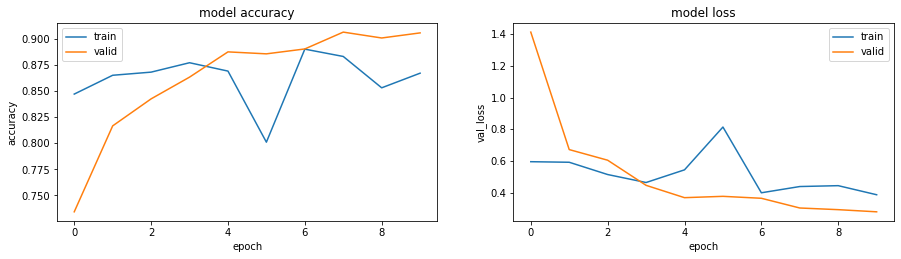

In [18]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['val_accuracy'])  
plt.plot(history.history['accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['val_loss'])  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('val_loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [19]:
test_data_dir= path+'test\\'
test_generator = data_generator.flow_from_directory(
    directory = test_data_dir,
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 115 images belonging to 1 classes.


In [22]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)
print(predicted_class_indices)

  2/115 [..............................] - ETA: 8s 

C:\Users\Tri\AppData\Local\Temp/ipykernel_20288/3127084481.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)


115/115 [==============================] - 9s 76ms/step
[0 0 0 0 0 1 1 1 0 1 1 0 1 2 0 2 1 1 0 0 0 0 1 0 0 1 0 1 2 1 2 2 1 0 2 2 1
 0 0 0 0 0 1 0 0 1 1 1 2 2 0 0 1 1 1 1 2 2 2 0 0 0 0 2 1 0 0 1 1 1 2 0 2 1
 1 0 0 0 1 1 1 0 0 1 2 2 2 2 2 1 1 0 2 2 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1
 1 2 2 0]


In [31]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)

results_df.to_csv('StrokeDetection1model1.csv', index=False)
results_df.head()

,id,label
0,1,0
83,1,1
82,1,0
81,1,0
80,1,1


In [24]:
df=pd.read_csv('StrokeDetection1.csv')
df

,id,label
0,1,0
1,1,1
2,1,0
3,1,0
4,1,1
...,...,...
110,1,1
111,1,2
112,1,2
113,1,2


In [25]:
df1=pd.read_csv('truthFile.csv')
df1

,Id,label
0,TEST\10090.png,0
1,TEST\10107.png,0
2,TEST\10155.png,2
3,TEST\10117.png,1
4,TEST\10188.png,1
...,...,...
110,TEST\16182.png,1
111,TEST\15735.png,0
112,TEST\16361.png,0
113,TEST\16557.png,0


In [26]:
tahmin=df['label']
tahmin

0      0
1      1
2      0
3      0
4      1
      ..
110    1
111    2
112    2
113    2
114    0
Name: label, Length: 115, dtype: int64

In [27]:
orijinal=df1['label']
orijinal

0      0
1      0
2      2
3      1
4      1
      ..
110    1
111    0
112    0
113    0
114    0
Name: label, Length: 115, dtype: int64

In [29]:
class_names=["0","1","2"]

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(orijinal, predicted_class_indices, target_names=class_names))

print(confusion_matrix(orijinal, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.49      0.34      0.40        64
           1       0.22      0.38      0.28        26
           2       0.33      0.32      0.33        25

    accuracy                           0.35       115
   macro avg       0.35      0.35      0.34       115
weighted avg       0.39      0.35      0.36       115

[[22 30 12]
 [12 10  4]
 [11  6  8]]
